<a href="https://colab.research.google.com/github/cuducquang/Deep-Learning/blob/main/version5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Setup Frameworks and Libraries

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Concatenate, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

## 2 - EDA

In [ ]:
data = np.load('dataset_dev_3000.npz')
X = data['X']   # Input images
y = data['y']   # Multi-target labels

# 2. Decompose Targets for Analysis
# y[:, 0]: Target A (Classification 0-9)
# y[:, 1]: Target B (Classification 0-31)
# y[:, 2]: Target C (Regression 0-1)
y_target_A = y[:, 0].astype(int)
y_target_B = y[:, 1].astype(int)
y_target_C = y[:, 2]

print("Data Loaded Successfully")
print(f"X Shape: {X.shape} | Type: {X.dtype}")
print(f"y Shape: {y.shape} | Type: {y.dtype}")
print("-" * 30)
print(f"Target A (Class 10): Unique values: {np.unique(y_target_A)}")
print(f"Target B (Class 32): Unique values count: {len(np.unique(y_target_B))}")
print(f"Target C (Regress):  Range [{y_target_C.min():.4f}, {y_target_C.max():.4f}]")

Data Loaded Successfully
X Shape: (3000, 32, 32) | Type: float32
y Shape: (3000, 3) | Type: float32
------------------------------
Target A (Class 10): Unique values: [0 1 2 3 4 5 6 7 8 9]
Target B (Class 32): Unique values count: 32
Target C (Regress):  Range [0.0003, 0.9996]


In [ ]:
# Check Pixel Intensity Statistics
print(" Pixel Value Statistics:")
print(f"Min : {X.min()}")
print(f"Max : {X.max()}")
print(f"Mean: {X.mean():.2f}")
print(f"Std : {X.std():.2f}")

# Check for Channel Dimension
if X.ndim == 3:
    print("Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.")
else:
    print("Images already have channel dimension.")

 Pixel Value Statistics:
Min : 5.5413776863133535e-05
Max : 6.8485941886901855
Mean: 0.81
Std : 0.74
Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.


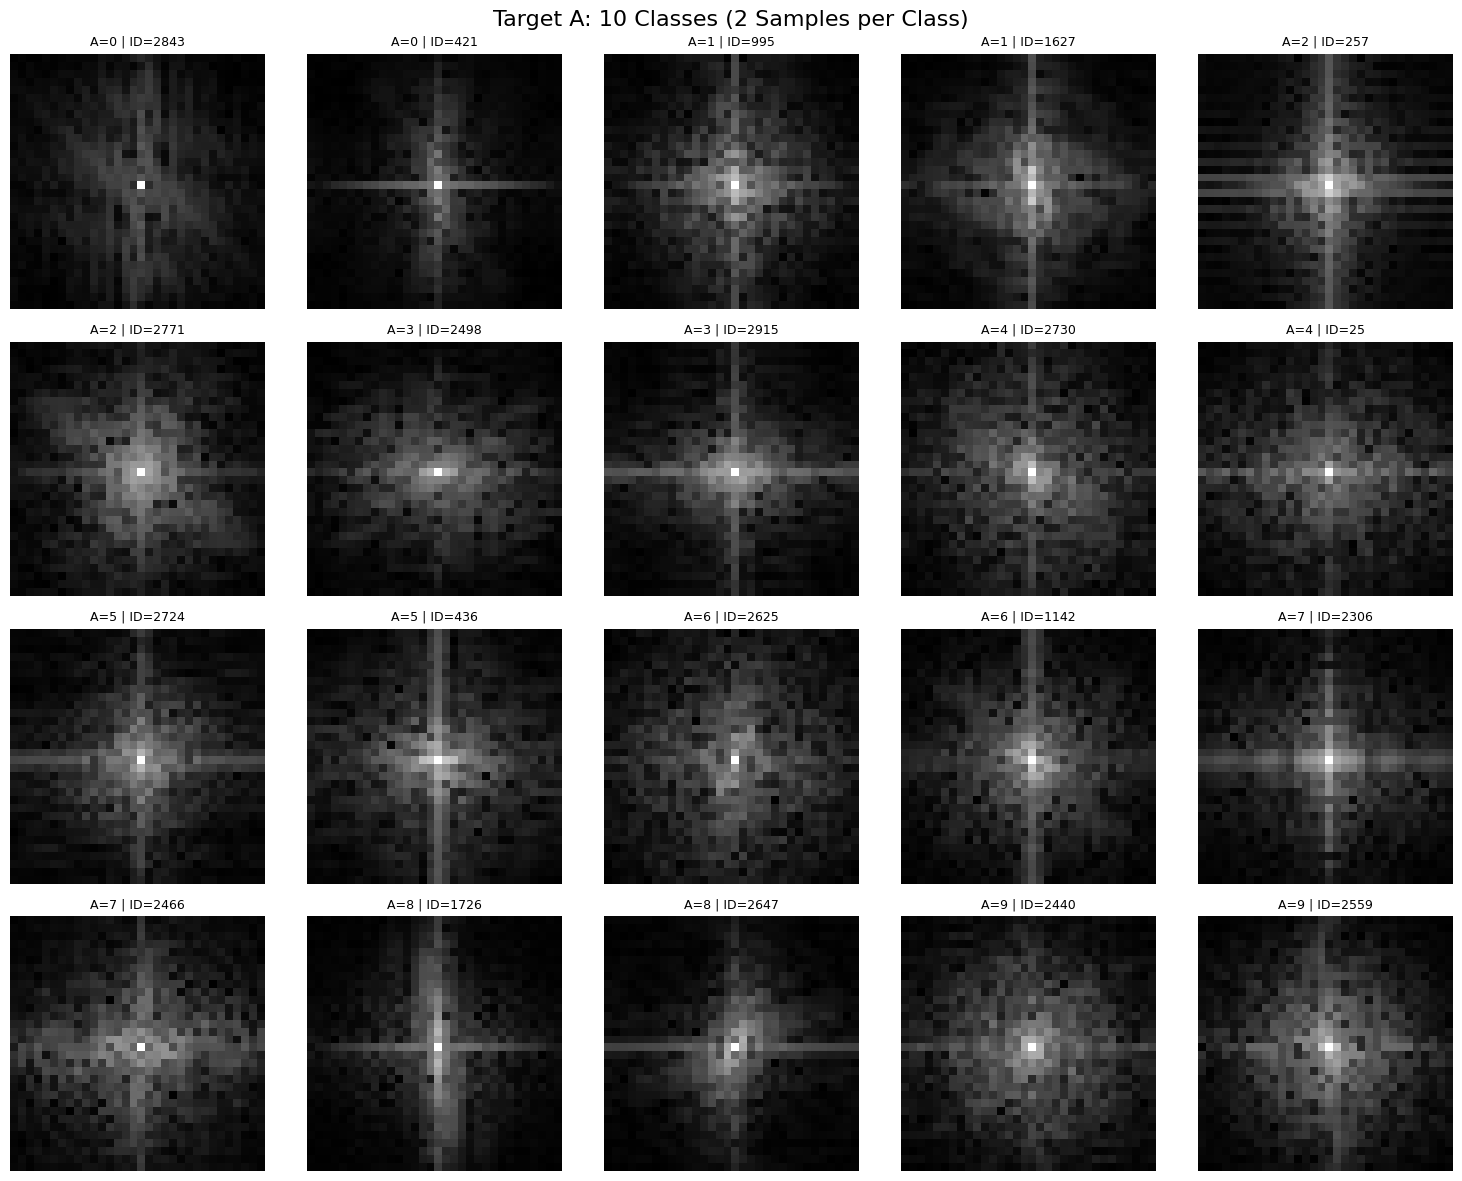

In [ ]:
# Visualize random samples with their 3 labels
# -------- FIGURE 1: Target A --------
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

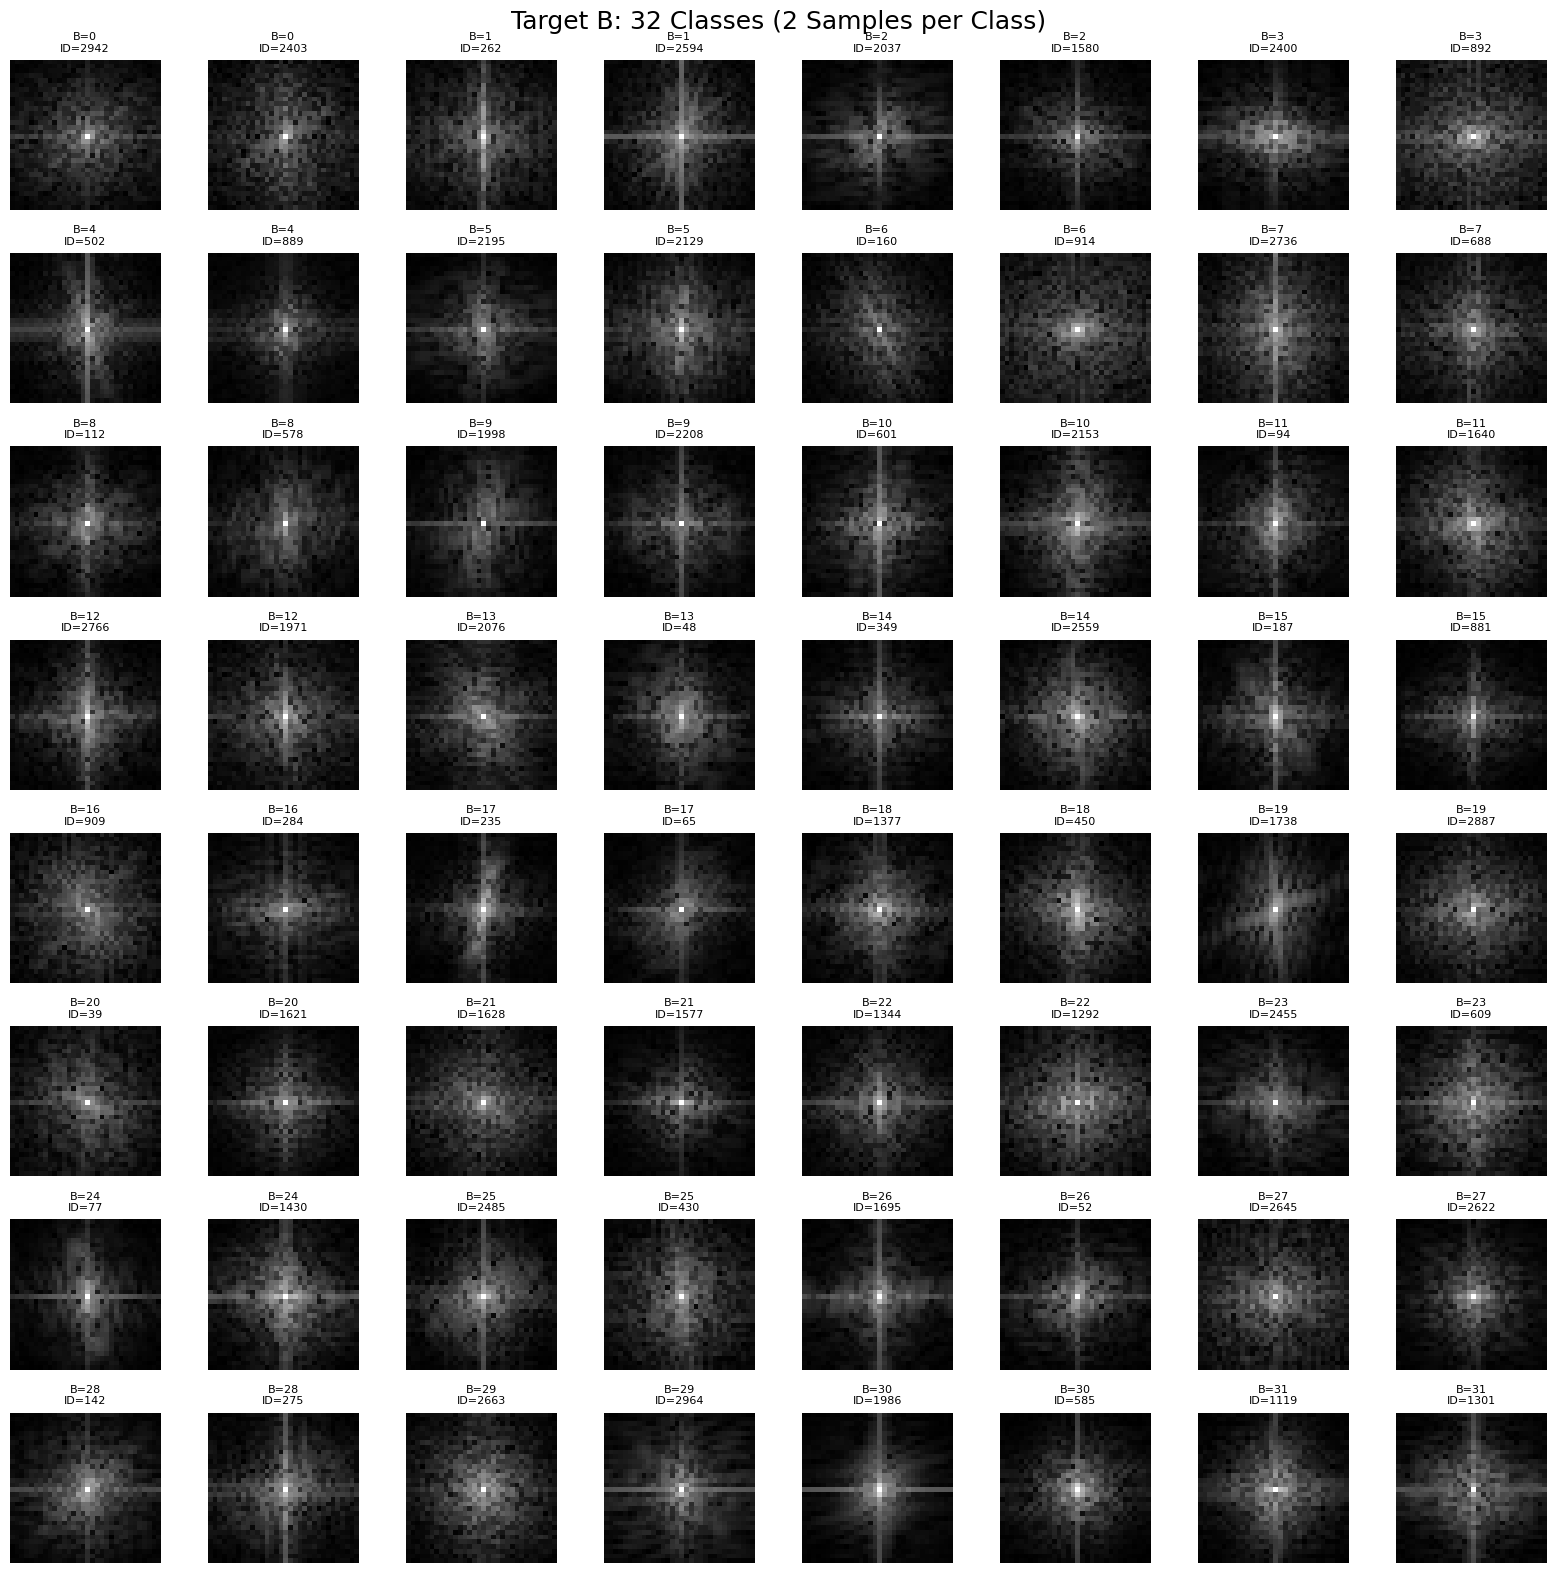

In [ ]:
# -------- FIGURE 2: Target B --------
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

plot_idx = 0
for cls in range(32):
    cls_indices = np.where(y_target_B == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"B={cls}\nID={idx}", fontsize=8)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target B: 32 Classes (2 Samples per Class)", fontsize=18)
plt.tight_layout()
plt.show()

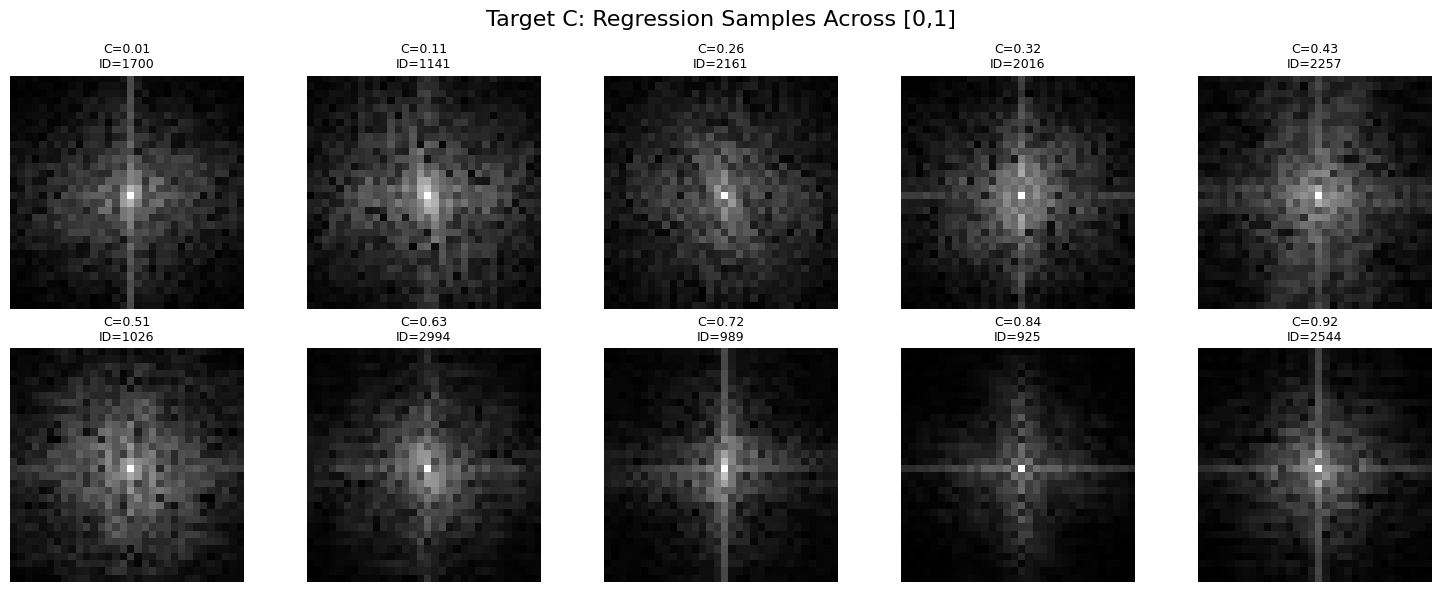

In [ ]:
# -------- FIGURE 3: Target C --------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

bins = np.linspace(0, 1, 11)

selected_indices = []
for i in range(10):
    bin_indices = np.where(
        (y_target_C >= bins[i]) & (y_target_C < bins[i+1])
    )[0]
    if len(bin_indices) > 0:
        selected_indices.append(np.random.choice(bin_indices))

for ax, idx in zip(axes, selected_indices):
    ax.imshow(X[idx], cmap='gray')
    ax.set_title(f"C={y_target_C[idx]:.2f}\nID={idx}", fontsize=9)
    ax.axis('off')

fig.suptitle("Target C: Regression Samples Across [0,1]", fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1890465473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_A, palette='viridis')


Target A Balance Check: {np.int64(0): np.int64(290), np.int64(1): np.int64(304), np.int64(2): np.int64(311), np.int64(3): np.int64(305), np.int64(4): np.int64(306), np.int64(5): np.int64(294), np.int64(6): np.int64(290), np.int64(7): np.int64(291), np.int64(8): np.int64(310), np.int64(9): np.int64(299)}


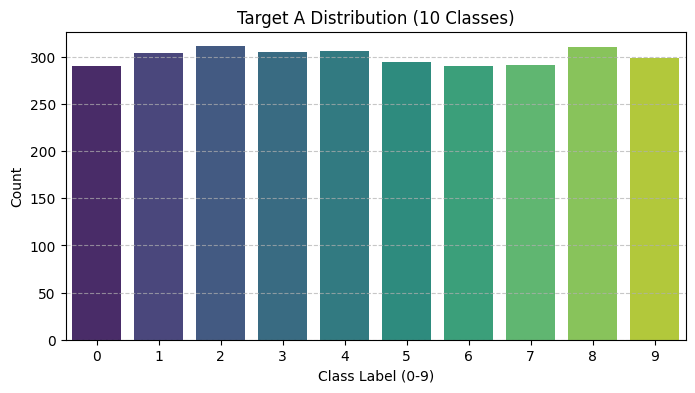

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_target_A, palette='viridis')
plt.title("Target A Distribution (10 Classes)")
plt.xlabel("Class Label (0-9)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Check exact counts
unique, counts = np.unique(y_target_A, return_counts=True)
print("Target A Balance Check:", dict(zip(unique, counts)))
plt.show()

/tmp/ipython-input-1059615394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_B, palette='magma')


Target B - Min samples per class: 75
Target B - Max samples per class: 113


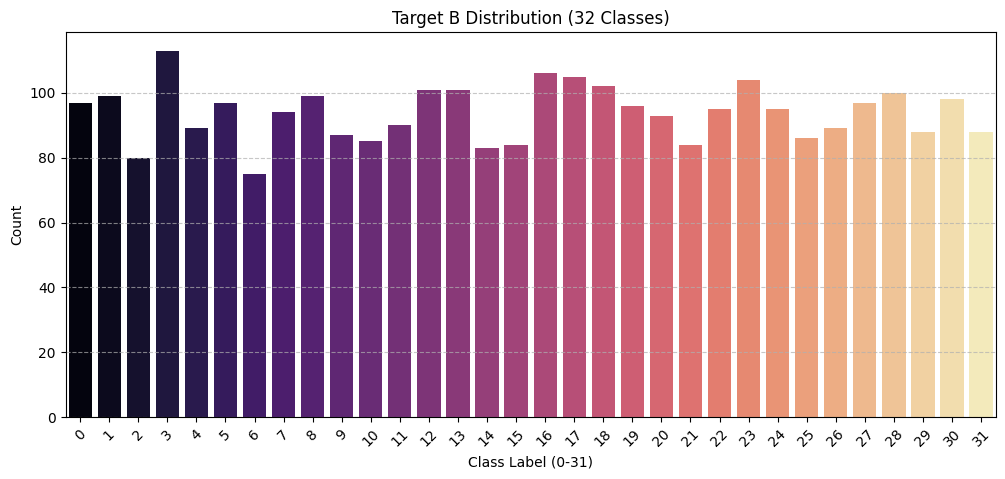

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(x=y_target_B, palette='magma')
plt.title("Target B Distribution (32 Classes)")
plt.xlabel("Class Label (0-31)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Statistics for Target B
unique_b, counts_b = np.unique(y_target_B, return_counts=True)
print(f"Target B - Min samples per class: {counts_b.min()}")
print(f"Target B - Max samples per class: {counts_b.max()}")
plt.show()

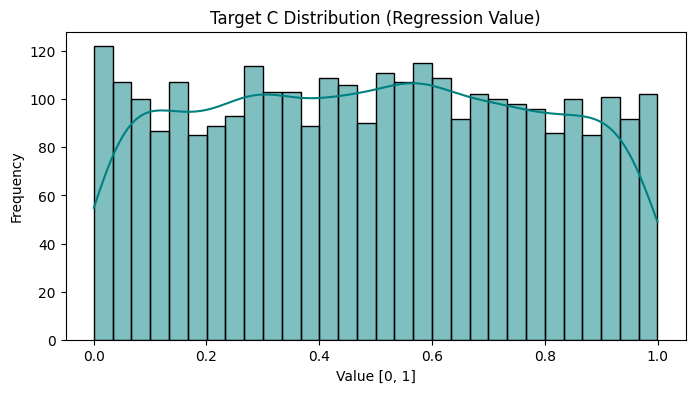

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(y_target_C, kde=True, bins=30, color='teal')
plt.title("Target C Distribution (Regression Value)")
plt.xlabel("Value [0, 1]")
plt.ylabel("Frequency")
plt.show()

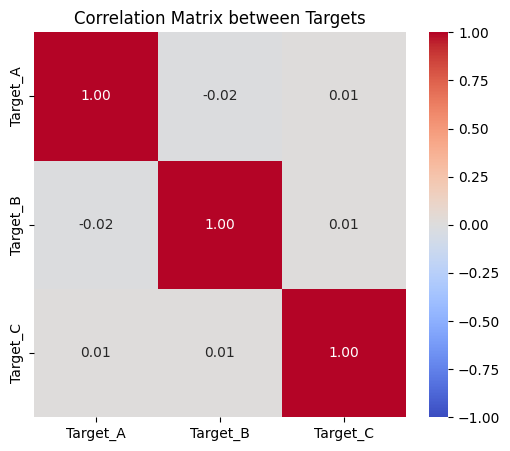

In [ ]:
# Create a DataFrame for correlation checking
df_targets = pd.DataFrame({
    'Target_A': y_target_A,
    'Target_B': y_target_B,
    'Target_C': y_target_C
})

# Compute Correlation Matrix
corr_matrix = df_targets.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix between Targets")
plt.show()

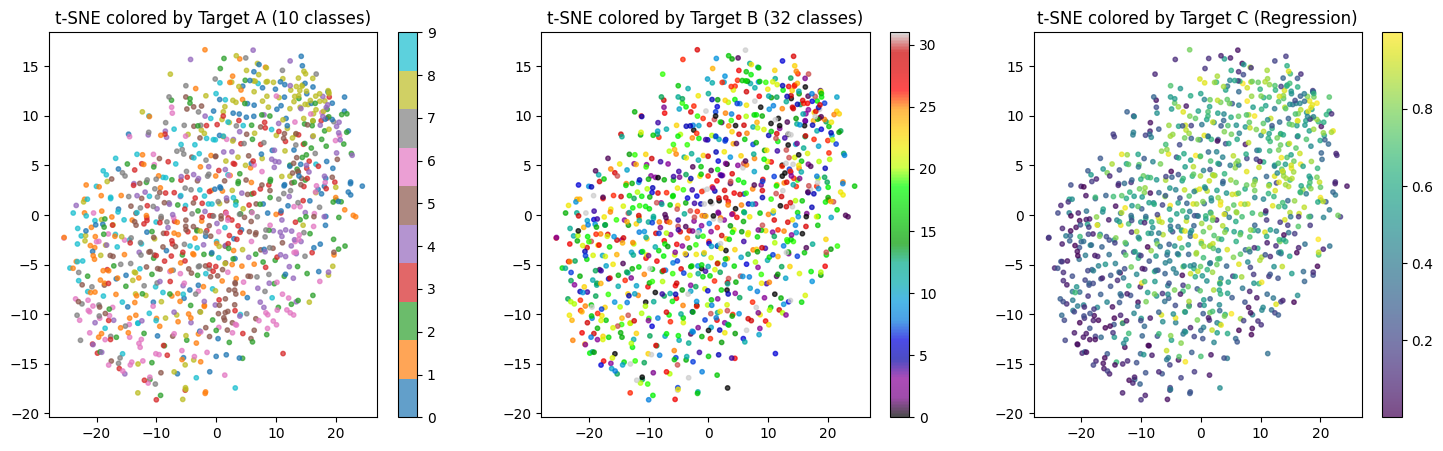

In [ ]:
# Subsample for speed (1000 samples)
idx_subset = np.random.choice(len(X), 1000, replace=False)
X_tsne_input = X[idx_subset].reshape(1000, -1)
y_tsne_A = y_target_A[idx_subset]
y_tsne_B = y_target_B[idx_subset]
y_tsne_C = y_target_C[idx_subset]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_tsne_input)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot colored by Target A
scatter1 = axes[0].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_A, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("t-SNE colored by Target A (10 classes)")
plt.colorbar(scatter1, ax=axes[0])

# Plot colored by Target B
scatter2 = axes[1].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_B, cmap='nipy_spectral', s=10, alpha=0.7)
axes[1].set_title("t-SNE colored by Target B (32 classes)")
plt.colorbar(scatter2, ax=axes[1])

# Plot colored by Target C
scatter3 = axes[2].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_C, cmap='viridis', s=10, alpha=0.7)
axes[2].set_title("t-SNE colored by Target C (Regression)")
plt.colorbar(scatter3, ax=axes[2])

plt.show()

## 3 - Data Preprocessing

In [ ]:
# 1. Normalize & Reshape
#  max value = 6.8485941886901855
MAX_PIXEL_VALUE = X.max()
X_norm = X.astype('float32') / MAX_PIXEL_VALUE
X_norm = np.expand_dims(X_norm, axis=-1) # (3000, 32, 32, 1)

# 2. Decompose Targets
y_A_raw = y[:, 0].astype(int)   # Class 0-9
y_B_raw = y[:, 1].astype(int)   # Class 0-31
y_C_raw = y[:, 2].astype(float) # Regression

# 3. Split Data (Train 70% - Val 15% - Test 15%)
# Split 1: Train vs Temp
X_train, X_temp, yA_train, yA_temp, yB_train, yB_temp, yC_train, yC_temp = train_test_split(
    X_norm, y_A_raw, y_B_raw, y_C_raw,
    test_size=0.3, random_state=42, stratify=y_B_raw
)

# Split 2: Val vs Test
X_val, X_test, yA_val, yA_test, yB_val, yB_test, yC_val, yC_test = train_test_split(
    X_temp, yA_temp, yB_temp, yC_temp,
    test_size=0.5, random_state=42, stratify=yB_temp
)

# 4. Target Encoding
# Target C: Reshape to (N, 1) for Regression
yC_train_reg = yC_train.reshape(-1, 1)
yC_val_reg   = yC_val.reshape(-1, 1)
yC_test_reg  = yC_test.reshape(-1, 1)

print(f"Train Set: {X_train.shape}")
print(f"Val Set:   {X_val.shape}")
print(f"Test Set:  {X_test.shape}")
print(f"Target A (Train) shape: {yA_train.shape} (Sparse/Integer)")

Train Set: (2100, 32, 32, 1)
Val Set:   (450, 32, 32, 1)
Test Set:  (450, 32, 32, 1)
Target A (Train) shape: (2100,) (Sparse/Integer)


In [ ]:
# 1. SETUP DATA AUGMENTATION
# A. Train Datagen
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

# B. Val/Test Datagen
val_datagen = ImageDataGenerator()

# 2. CUSTOM GENERATOR WRAPPER
def multi_output_data_generator(X, yA, yB, yC, batch_size, datagen):
    indices = np.arange(len(X))
    gen_X = datagen.flow(X, indices, batch_size=batch_size, shuffle=True)

    while True:
        X_batch, idx_batch = next(gen_X)
        yA_batch = yA[idx_batch]
        yB_batch = yB[idx_batch]
        yC_batch = yC[idx_batch]

        yield X_batch, {
            'output_A': yA_batch,
            'output_B': yB_batch,
            'output_C': yC_batch
        }

# 3. INSTANTIATE GENERATORS
BATCH_SIZE = 32

train_gen = multi_output_data_generator(
    X_train, yA_train, yB_train, yC_train_reg,
    batch_size=BATCH_SIZE,
    datagen=train_datagen
)

val_gen = multi_output_data_generator(
    X_val, yA_val, yB_val, yC_val_reg,
    batch_size=BATCH_SIZE,
    datagen=val_datagen
)

## 4 - Model Architecture

In [ ]:
# --- Helper Function: Residual Lite Block ---
def residual_lite_block(x, filters, kernel_size=3, name='res'):
    shortcut = x

    # Conv 1
    x = Conv2D(filters, kernel_size, padding='same',
               kernel_initializer='he_normal', name=f'{name}_conv1')(x)
    x = BatchNormalization(name=f'{name}_bn1')(x)
    x = Activation('relu', name=f'{name}_relu1')(x)

    # Conv 2
    x = Conv2D(filters, kernel_size, padding='same',
               kernel_initializer='he_normal', name=f'{name}_conv2')(x)
    x = BatchNormalization(name=f'{name}_bn2')(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same',
                          kernel_initializer='he_normal', name=f'{name}_proj')(shortcut)
        shortcut = BatchNormalization(name=f'{name}_proj_bn')(shortcut)

    x = Add(name=f'{name}_add')([x, shortcut])
    x = Activation('relu', name=f'{name}_out')(x)
    return x

# --- Main Hypermodel ---
def build_hypermodel(hp):
    inputs = Input(shape=(32, 32, 1), name='input_image')

    # ===== 1. SHARED STEM (Feature Extractor) =====

    # Stem Block 1
    f1 = hp.Int('stem_f1', 32, 64, step=32)
    x = Conv2D(f1, 3, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

    # Stem Block 2
    f2 = hp.Int('stem_f2', 64, 128, step=32)
    x = Conv2D(f2, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

    # Shared Residual Bottleneck
    x = residual_lite_block(x, f2, name='stem_res')

    shared_features_map = x

    # ===== 2. TASK-SPECIFIC BRANCHES (Dynamic Config) =====

    # --- Branch A (10 classes) ---
    a_filters = hp.Int('branch_A_filters', 32, 64, step=32)
    a = residual_lite_block(shared_features_map, a_filters, name='branchA_res')
    a = GlobalAveragePooling2D()(a)
    a = Dense(hp.Int('dense_A', 32, 128, step=32), activation='relu')(a)

    dropout_a = hp.Float('dropout_A', min_value=0.2, max_value=0.4, step=0.1)
    a = Dropout(dropout_a)(a)

    output_a = Dense(10, activation='softmax', name='output_A')(a)

    # --- Branch B (32 classes) - HEAVY BRANCH ---
    b_filters = hp.Int('branch_B_filters', 64, 128, step=32)
    b = residual_lite_block(shared_features_map, b_filters, name='branchB_res1')
    b = residual_lite_block(b, b_filters, name='branchB_res2')
    b = GlobalAveragePooling2D()(b)
    b = Dense(hp.Int('dense_B', 128, 256, step=64), activation='relu')(b)

    dropout_b = hp.Float('dropout_B', min_value=0.3, max_value=0.5, step=0.1)
    b = Dropout(dropout_b)(b)

    output_b = Dense(32, activation='softmax', name='output_B')(b)

    # --- Branch C (Regression) ---
    c_filters = hp.Int('branch_C_filters', 32, 64, step=32)
    c = residual_lite_block(shared_features_map, c_filters, name='branchC_res')
    c = GlobalAveragePooling2D()(c)
    c = Dense(hp.Int('dense_C', 32, 64, step=32), activation='relu')(c)
    output_c = Dense(1, activation='sigmoid', name='output_C')(c)

    # ===== 3. COMPILE WITH DYNAMIC LOSS WEIGHTS =====
    model = Model(inputs, [output_a, output_b, output_c], name="MultiTask_Asymmetric_ResNet_Dynamic")

    w_A = hp.Choice('loss_weight_A', values=[0.5, 1.0, 2.0])
    w_B = hp.Choice('loss_weight_B', values=[1.0, 2.0, 3.0])
    w_C = hp.Choice('loss_weight_C', values=[5.0, 10.0, 20.0])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4])),
        loss={
            'output_A': 'sparse_categorical_crossentropy',
            'output_B': 'sparse_categorical_crossentropy',
            'output_C': 'mse'
        },
        loss_weights={
            'output_A': w_A,
            'output_B': w_B,
            'output_C': w_C
        },
        metrics={
            'output_A': 'accuracy',
            'output_B': 'accuracy',
            'output_C': 'mae'
        }
    )
    return model

class CompositeScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc_A = logs.get('val_output_A_accuracy', 0.0)
        val_acc_B = logs.get('val_output_B_accuracy', 0.0)
        val_mae_C = logs.get('val_output_C_mae', 1.0)

        score = val_acc_A + val_acc_B + (1.0 - val_mae_C) # max = 3
        logs['val_composite_score'] = score

metrics_callback = CompositeScoreCallback()

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_composite_score',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# --- Setup Tuner ---
tuner = kt.BayesianOptimization(
    build_hypermodel,
    objective=kt.Objective("val_composite_score", direction="max"),
    max_trials=30,
    num_initial_points=5,
    directory='bayesian_tuning_final',
    project_name='multitask_sparse',
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 14
stem_f1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
stem_f2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
branch_A_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
dense_A (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_A (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
branch_B_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_B (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_B (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step

## 5 - Fine-tune Search

In [ ]:
print("\n Starting Bayesian Optimization Search...")
print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print("-" * 50)

tuner.search(
    train_gen,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(X_val) // BATCH_SIZE,
    epochs=20,
    callbacks=[metrics_callback, early_stopping, reduce_lr]
)

Trial 30 Complete [00h 05m 37s]
val_composite_score: 1.2290204614400864

Best val_composite_score So Far: 1.3148486614227295
Total elapsed time: 05h 03m 06s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

best_model = tuner.hypermodel.build(best_hp)

Best hyperparameters:
stem_f1: 64
stem_f2: 128
branch_A_filters: 64
dense_A: 128
dropout_A: 0.4
branch_B_filters: 64
dense_B: 256
dropout_B: 0.4
branch_C_filters: 64
dense_C: 64
loss_weight_A: 1.0
loss_weight_B: 3.0
loss_weight_C: 20.0
learning_rate: 0.001


## 6 - Training Model

Starting Training (Multi-Task)...
Epoch 1/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 478ms/step - loss: 13.9629 - output_A_accuracy: 0.1246 - output_A_loss: 2.3250 - output_B_accuracy: 0.0351 - output_B_loss: 3.5431 - output_C_loss: 0.0504 - output_C_mae: 0.1818 - val_loss: 13.9666 - val_output_A_accuracy: 0.0933 - val_output_A_loss: 2.3376 - val_output_B_accuracy: 0.0335 - val_output_B_loss: 3.4654 - val_output_C_loss: 0.0592 - val_output_C_mae: 0.2046 - val_composite_score: 0.9222 - learning_rate: 0.0010
Epoch 2/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - loss: 13.0216 - output_A_accuracy: 0.2233 - output_A_loss: 2.1091 - output_B_accuracy: 0.0390 - output_B_loss: 3.4536 - output_C_loss: 0.0275 - output_C_mae: 0.1335 - val_loss: 14.7461 - val_output_A_accuracy: 0.1124 - val_output_A_loss: 3.3028 - val_output_B_accuracy: 0.0407 - val_output_B_loss: 3.4820 - val_output_C_loss: 0.0469 - val_output_C_mae: 0.1666 - val_composite_score: 0.9865 - learning_rate: 0.0010
Epoch 3/70
65/65 ━━━━━━━━━━━

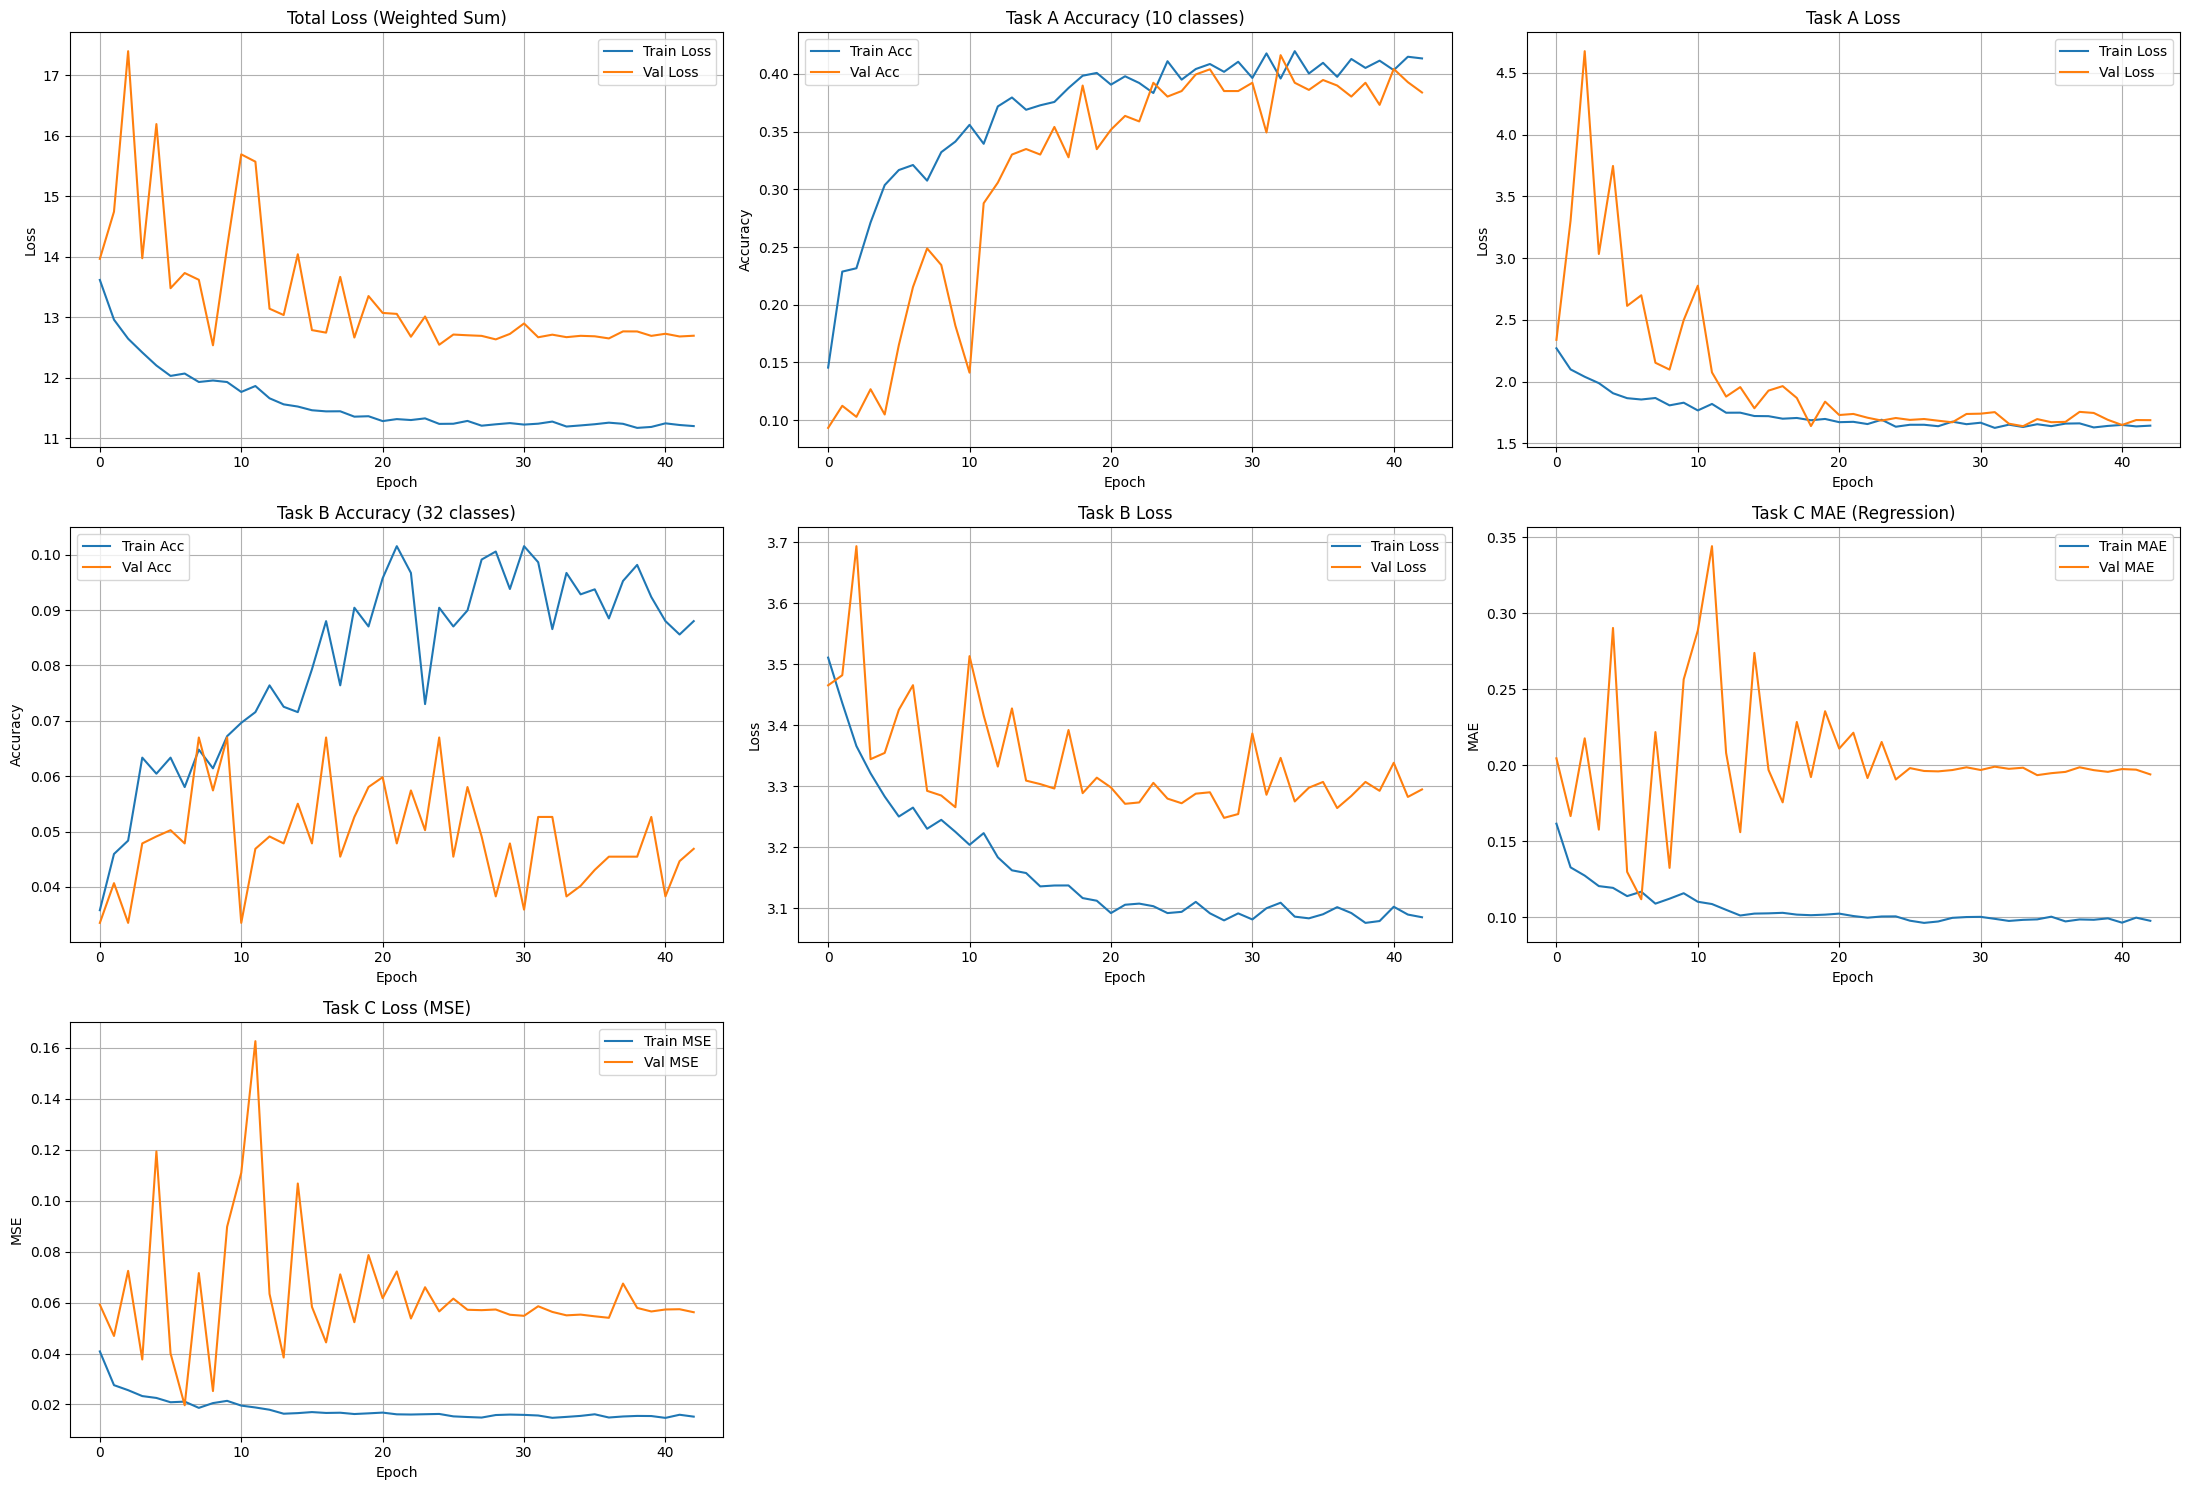

In [ ]:
steps_per_epoch  = len(X_train) // BATCH_SIZE
validation_steps = len(X_val)   // BATCH_SIZE

print("Starting Training (Multi-Task)...")

history = best_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=70,
    callbacks=[metrics_callback, early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

# VISUALIZE TRAINING HISTORY
fig, axes = plt.subplots(3, 3, figsize=(22, 15))

# ========== TOTAL LOSS ==========
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Total Loss (Weighted Sum)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# ========== TASK A ==========
axes[0, 1].plot(history.history['output_A_accuracy'], label='Train Acc')
axes[0, 1].plot(history.history['val_output_A_accuracy'], label='Val Acc')
axes[0, 1].set_title('Task A Accuracy (10 classes)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(history.history['output_A_loss'], label='Train Loss')
axes[0, 2].plot(history.history['val_output_A_loss'], label='Val Loss')
axes[0, 2].set_title('Task A Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# ========== TASK B ==========
axes[1, 0].plot(history.history['output_B_accuracy'], label='Train Acc')
axes[1, 0].plot(history.history['val_output_B_accuracy'], label='Val Acc')
axes[1, 0].set_title('Task B Accuracy (32 classes)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history.history['output_B_loss'], label='Train Loss')
axes[1, 1].plot(history.history['val_output_B_loss'], label='Val Loss')
axes[1, 1].set_title('Task B Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

# ========== TASK C ==========
axes[1, 2].plot(history.history['output_C_mae'], label='Train MAE')
axes[1, 2].plot(history.history['val_output_C_mae'], label='Val MAE')
axes[1, 2].set_title('Task C MAE (Regression)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

# ========== TASK C LOSS (MSE) ==========
axes[2, 0].plot(history.history['output_C_loss'], label='Train MSE')
axes[2, 0].plot(history.history['val_output_C_loss'], label='Val MSE')
axes[2, 0].set_title('Task C Loss (MSE)')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('MSE')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
MODEL_FILENAME = 'groupId_model.h5'
best_model.save(MODEL_FILENAME)
print("Model trained and saved.")
best_model.summary()

Model trained and saved.


Model: "MultiTask_Asymmetric_ResNet_Dynamic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        640 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_conv1      │ (None, 8, 8, 128) │    147,584 │ max_pooling2d_3[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_bn1        │ (None, 8, 8, 128) │        512 │ stem_res_conv1[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_relu1      │ (None, 8, 8, 128) │          0 │ stem_res_bn1[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_conv2      │ (None, 8, 8, 128) │    147,584 │ stem_res_relu1[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_bn2        │ (None, 8, 8, 128) │        512 │ stem_res_conv2[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_add (Add)  │ (None, 8, 8, 128) │          0 │ stem_res_bn2[0][… │
│                     │                   │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_res_out        │ (None, 8, 8, 128) │          0 │ stem_res_add[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branchB_res1_conv1  │ (None, 8, 8, 64)  │     73,792 │ stem_res_out[0][

 Total params: 2,526,659 (9.64 MB)

 Trainable params: 841,451 (3.21 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 1,682,904 (6.42 MB)

## 7 - Model Evaluation

 Running Comprehensive Evaluation on Test Set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 12.9887 - output_A_accuracy: 0.3874 - output_A_loss: 1.7549 - output_B_accuracy: 0.0680 - output_B_loss: 3.2721 - output_C_loss: 0.0720 - output_C_mae: 0.2228

 === Global Metrics ===
loss: 12.9269
compile_metrics: 1.8457
output_A_loss: 3.2698
output_B_loss: 0.0722
output_C_loss: 0.3778

 Generating Predictions...

 TARGET A (10 Classes) - CLASSIFICATION
 Accuracy: 0.3778

Classification Report:

              precision    recall  f1-score   support

           0     0.8571    0.1277    0.2222        47
           1     0.3846    0.2500    0.3030        40
           2     0.1429    0.0408    0.0635        49
           3     0.2941    0.1923    0.2326        52
           4     0.2941    0.3846    0.3333        39
           5     0.3409    0.3750    0.3571        40
           6     0.3803    0.5510    0.4500        49
           7     0.3438    0.4783    0.4000        46
           8    

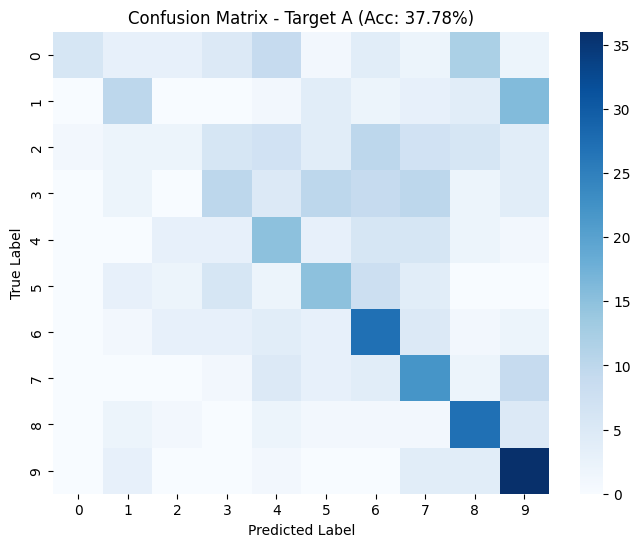


 TARGET B (32 Classes) - CLASSIFICATION
 Top-1 Accuracy: 0.0622
 Top-5 Accuracy: 0.2889 (Model captures semantics well?)

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.1200    0.2000    0.1500        15
           2     0.0000    0.0000    0.0000        12
           3     0.0000    0.0000    0.0000        17
           4     0.1538    0.1538    0.1538        13
           5     0.0000    0.0000    0.0000        15
           6     0.0000    0.0000    0.0000        12
           7     0.0000    0.0000    0.0000        14
           8     0.0312    0.0667    0.0426        15
           9     0.0000    0.0000    0.0000        13
          10     0.0000    0.0000    0.0000        13
          11     0.0000    0.0000    0.0000        13
          12     0.0427    0.3333    0.0758        15
          13     0.0400    0.1333    0.0615        15
          14     0.0000    0.0000    0.000

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


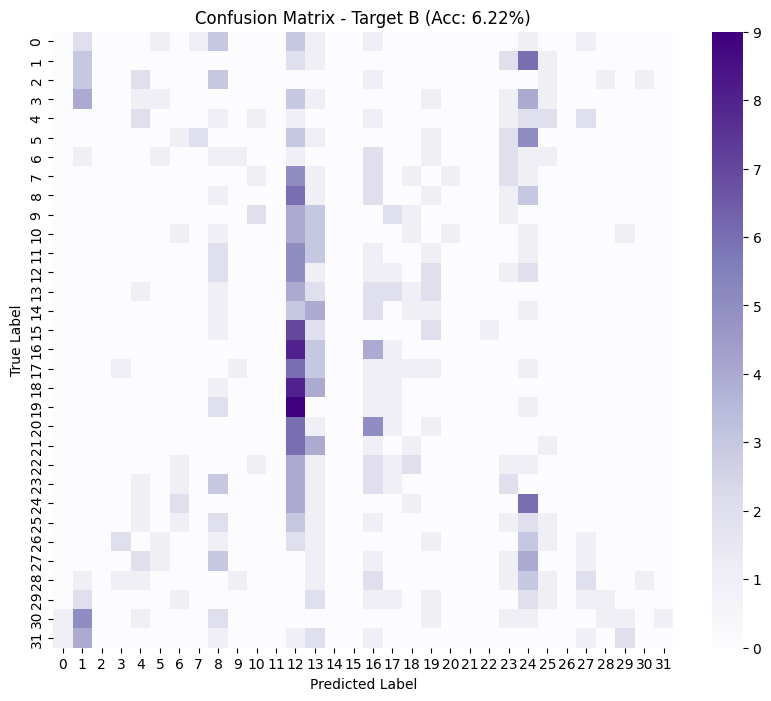


 TARGET C (Regression) - CONTINUOUS VALUE
 Mean Absolute Error (MAE): 0.2162
 Mean Squared Error (MSE):  0.0679
 R-squared Score (R²):      0.1847


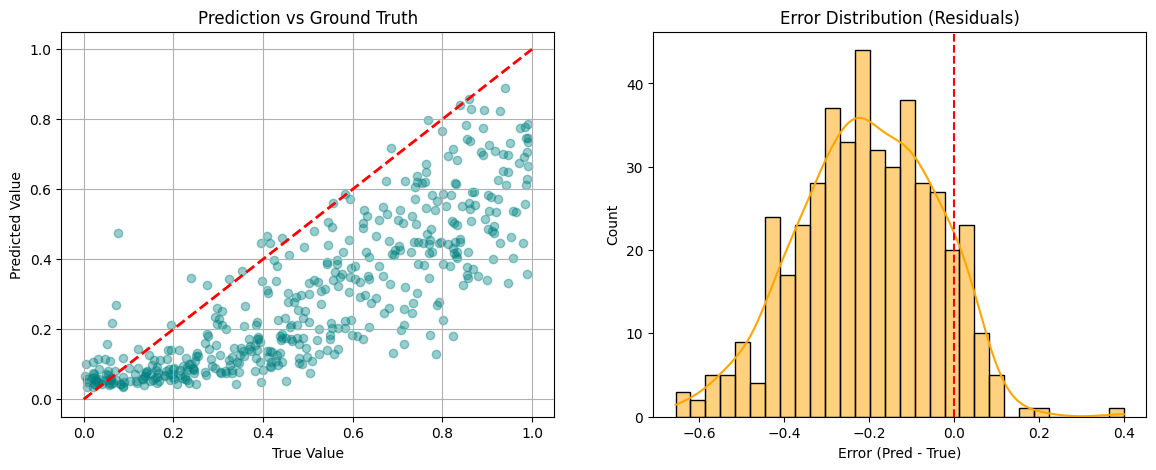


 JOINT PERFORMANCE ANALYSIS
 Exact Match Ratio (All 3 Correct): 0.0000
   (Criteria: Class A correct & Class B correct & Reg C error < 0.05)

 Analyzing 214 Complete Failures (Wrong on A, B, and C):


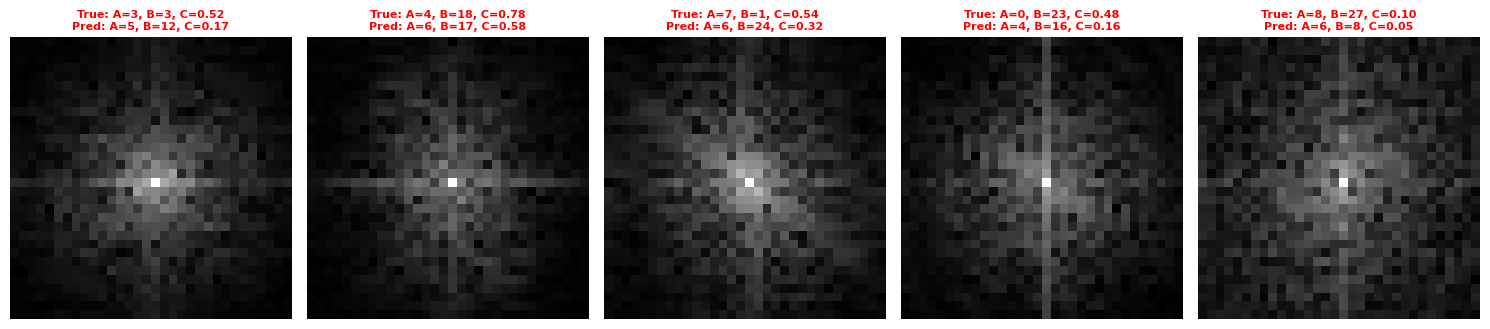

In [ ]:
# 1. OVERALL EVALUATION (LOSS & METRICS)
print(" Running Comprehensive Evaluation on Test Set...")

# Evaluate using Keras built-in function
eval_results = best_model.evaluate(
    X_test,
    {
        'output_A': yA_test,
        'output_B': yB_test,
        'output_C': yC_test_reg
    },
    verbose=1
)

print("\n === Global Metrics ===")
for name, val in zip(best_model.metrics_names, eval_results):
    print(f"{name}: {val:.4f}")

# 2. GENERATE PREDICTIONS
print("\n Generating Predictions...")
pred_A_prob, pred_B_prob, pred_C = best_model.predict(X_test, verbose=0)

# Convert probabilities to class indices
pred_A = np.argmax(pred_A_prob, axis=1)
pred_B = np.argmax(pred_B_prob, axis=1)
pred_C = pred_C.flatten() # Flatten regression output to 1D array

# 3. TARGET A EVALUATION (0-9 Digits)
print("\n" + "="*40)
print(" TARGET A (10 Classes) - CLASSIFICATION")
print("="*40)

acc_A = accuracy_score(yA_test, pred_A)
print(f" Accuracy: {acc_A:.4f}")
print("\nClassification Report:\n")
print(classification_report(yA_test, pred_A, digits=4))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm_A = confusion_matrix(yA_test, pred_A)
sns.heatmap(cm_A, annot=False, cmap='Blues', cbar=True)
plt.title(f"Confusion Matrix - Target A (Acc: {acc_A:.2%})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4. TARGET B EVALUATION (0-31 Classes)
print("\n" + "="*40)
print(" TARGET B (32 Classes) - CLASSIFICATION")
print("="*40)

acc_B = accuracy_score(yB_test, pred_B)
print(f" Top-1 Accuracy: {acc_B:.4f}")

# Calculate Top-5 Accuracy
yB_test_onehot = tf.keras.utils.to_categorical(yB_test, 32)
top5_acc = tf.keras.metrics.top_k_categorical_accuracy(yB_test_onehot, pred_B_prob, k=5)
print(f" Top-5 Accuracy: {np.mean(top5_acc):.4f} (Model captures semantics well?)")

print("\nClassification Report:\n")
print(classification_report(yB_test, pred_B, digits=4))

# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
cm_B = confusion_matrix(yB_test, pred_B)
sns.heatmap(cm_B, annot=False, cmap='Purples', cbar=True)
plt.title(f"Confusion Matrix - Target B (Acc: {acc_B:.2%})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 5. TARGET C EVALUATION (Regression)
print("\n" + "="*40)
print(" TARGET C (Regression) - CONTINUOUS VALUE")
print("="*40)

mae = mean_absolute_error(yC_test_reg, pred_C)
mse = mean_squared_error(yC_test_reg, pred_C)
r2 = r2_score(yC_test_reg, pred_C)

print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" Mean Squared Error (MSE):  {mse:.4f}")
print(f" R-squared Score (R²):      {r2:.4f}")

# Visualization: Scatter Plot & Residual Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter Plot
axes[0].scatter(yC_test_reg, pred_C, alpha=0.4, color='teal')
axes[0].plot([0, 1], [0, 1], 'r--', lw=2) # Perfect prediction line
axes[0].set_title("Prediction vs Ground Truth")
axes[0].set_xlabel("True Value")
axes[0].set_ylabel("Predicted Value")
axes[0].grid(True)

# Residual Histogram (Check for Bias)
errors = pred_C - yC_test_reg.flatten()
sns.histplot(errors, kde=True, ax=axes[1], color='orange', bins=30)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_title("Error Distribution (Residuals)")
axes[1].set_xlabel("Error (Pred - True)")
plt.show()

# 6. JOINT ACCURACY & FAILURE ANALYSIS (Multi-task Insight)
print("\n" + "="*40)
print(" JOINT PERFORMANCE ANALYSIS")
print("="*40)

# Define correctness criteria
threshold_C = 0.05
correct_A = (pred_A == yA_test)
correct_B = (pred_B == yB_test)
correct_C = (np.abs(errors) < threshold_C)

# Joint Accuracy: Correct on ALL 3 targets
joint_correct = correct_A & correct_B & correct_C
joint_acc = np.mean(joint_correct)

print(f" Exact Match Ratio (All 3 Correct): {joint_acc:.4f}")
print(f"   (Criteria: Class A correct & Class B correct & Reg C error < {threshold_C})")

# Visualize Worst Failures (Wrong on ALL 3 targets)
failures = np.where(~correct_A & ~correct_B & ~correct_C)[0]

if len(failures) > 0:
    print(f"\n Analyzing {len(failures)} Complete Failures (Wrong on A, B, and C):")
    n_show = min(5, len(failures))
    fig, axes = plt.subplots(1, n_show, figsize=(15, 4))
    if n_show == 1: axes = [axes] # Handle single case

    for i, idx in enumerate(failures[:n_show]):
        ax = axes[i]
        # Reshape & Scale back for display if needed
        img = X_test[idx].squeeze()
        ax.imshow(img, cmap='gray')

        title = (f"True: A={yA_test[idx]}, B={yB_test[idx]}, C={yC_test_reg[idx][0]:.2f}\n"
                 f"Pred: A={pred_A[idx]}, B={pred_B[idx]}, C={pred_C[idx]:.2f}")
        ax.set_title(title, fontsize=8, color='red', fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\n Amazing! No samples failed on all 3 targets simultaneously.")